In [1]:
# This is just an example of how to prepare the Jupyter notebook for plotting and is not strictly necessary.
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = [10, 5]

# Some imports to help with type annotations and other things later on.
from typing import List, Tuple
from pandas import DataFrame
from lmfit import fit_report
from numpy import array, ndarray, log10 as log, logspace
from numpy.random import seed, normal
seed(42)

# Getting started with _pyimpspec_

In [2]:
from pyimpspec import *  # Imports all of the relevant classes and functions for the top-level API.
from pyimpspec.plot.mpl import *  # Imports the functions for plotting pyimpspec's various objects.

## Loading experimental data

Loading experimental data can be done with the `parse_data` function, which is a wrapper for the various file format parsers.
Some of the supported file formats may contain multiple spectra in a single file and thus the `parse_data` function always returns a list of `DataSet` objects.

In [3]:
spectra: List[DataSet] = parse_data("./example-data.csv")
spectrum: DataSet = spectra[0]
spectrum.set_label("Ideal")

## Plotting impedance spectra

The `plot_data` function provides a quick way to plot an impedance spectrum as both Nyquist (right) and Bode (left) plots.

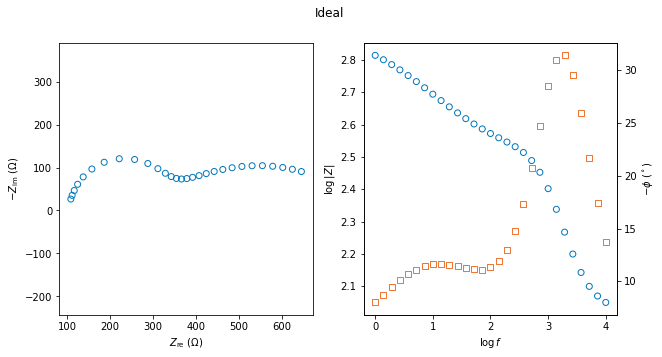

In [4]:
fig, axes = plot_data(spectrum)

## Dealing with outliers

Individual data points can be masked (i.e. omitted) by applying a mask, which is simply a dictionary with zero-based integer indices as keys and boolean values.
`True` means that the data point is masked/omitted.

27
27
2
29


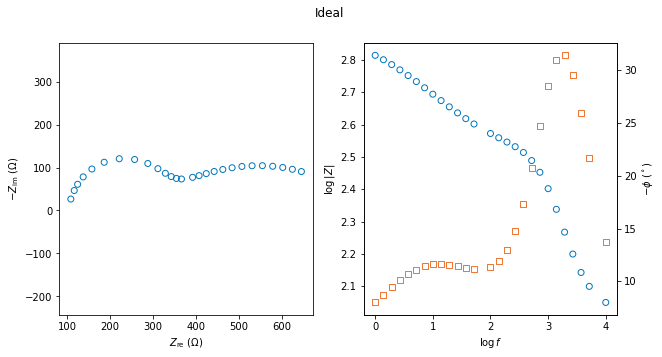

In [5]:
spectrum.set_mask({
    1: True,  # Mask the second point.
    15: True,  # Mask the sixteenth point.
})
fig, axes = plot_data(spectrum)

print(len(spectrum.get_impedance()))  # Get the impedances that have not been omitted.
print(len(spectrum.get_impedance(masked=False)))  # Same as the line above.
print(len(spectrum.get_impedance(masked=True)))  # Get the omitted impedances.
print(len(spectrum.get_impedance(masked=None)))  # Get all of the impedances.

## Subtracting impedances

The `subtract_impedance` method accepts a single complex value or a list (or a _numpy_ array) of complex values, and can be used to e.g. make corrections.

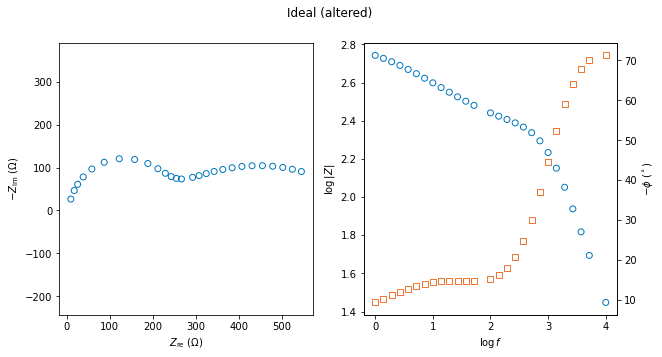

In [6]:
altered_spectrum: DataSet = DataSet.copy(spectrum, label="Ideal (altered)")
altered_spectrum.subtract_impedance(complex(100, 0))
fig, axes = plot_data(altered_spectrum)

## Averaging noisy spectra

Multiple noisy spectra can be averaged to generate a single `DataSet` object.

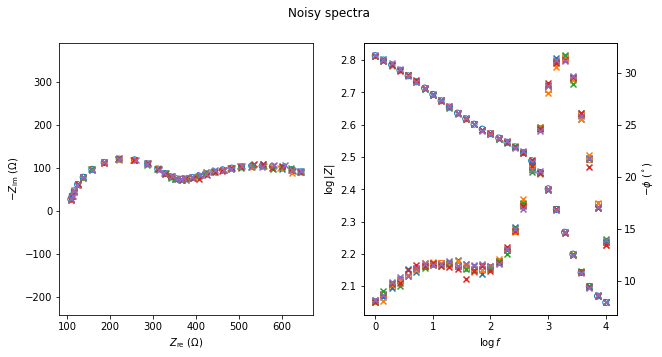

In [7]:
spectrum.set_mask({})  # Reset the mask
fig, axes = plot_data(spectrum)
fig.suptitle("Noisy spectra")

# First we create several noisy versions of the original DataSet for demonstration purposes.
noisy_spectra: List[DataSet] = []
i: int
for i in range(0, 5):
    sd: float = 0.005
    Z: complex
    noise: ndarray = array(list(map(lambda Z: complex(
        abs(Z) * normal(0, sd, 1),
        abs(Z) * normal(0, sd, 1),
    ), spectrum.get_impedance(masked=None))))  # Get all of the data points regardless of the applied mask.
    noisy_spectra.append(DataSet.copy(spectrum, label=f"Noisy ({i + 1})"))  # Create a copy of the original DataSet.
    noisy_spectra[-1].subtract_impedance(-noise)  # Add noise to the new DataSet.
    axes[0].scatter(*noisy_spectra[-1].get_nyquist_data(), marker="x")
    x, y1, y2 = noisy_spectra[-1].get_bode_data()
    axes[1].scatter(x, y1, marker="x")
    axes[2].scatter(x, y2, marker="x")

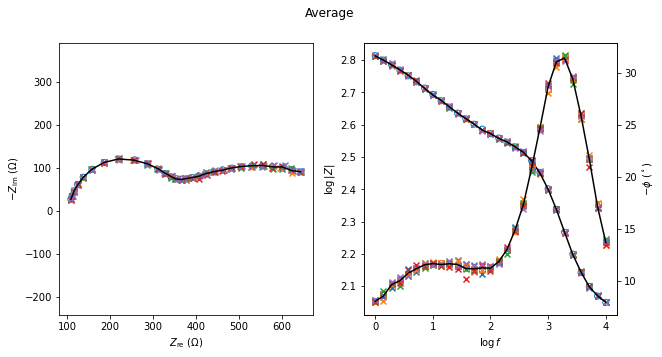

In [8]:
# Now we average the noisy spectra to create one averaged spectrum.
average: DataSet = DataSet.average(noisy_spectra)
axes[0].plot(*average.get_nyquist_data(), color="black")
x, y1, y2 = average.get_bode_data()
axes[1].plot(x, y1, color="black")
axes[2].plot(x, y2, color="black")
fig.suptitle("Average")
fig

## Performing Kramers-Kronig tests

Checking whether or not an impedance spectrum is Kramers-Kronig transformable is a common way to check the validity of an impedance spectrum.
The `perform_test` function is capable of performing different implementations of the linear Kramers-Kronig test based on the arguments that are passed to the function.
By default the complex test[[1]](https://iopscience.iop.org/article/10.1149/1.2044210/meta) is used and the number of RC elements connected in series is determined based on the µ-criterion[[2]](https://www.sciencedirect.com/science/article/abs/pii/S0013468614001005).
However, it is possible to specify another test and/or the number of RC elements to use.

In [9]:
mu_criterion: float = 0.85
test: KramersKronigResult = perform_test(average, add_capacitance=True, mu_criterion=mu_criterion)

The `plot_fit` function can be used to visualize the results since that is essentially what the linear Kramers-Kronig test does (i.e. a circuit, which is known _a priori_ to be Kramers-Kronig transformable, is fitted to the experimental data).
The figure contains Nyquist and Bode plots, and a plot of the residuals.

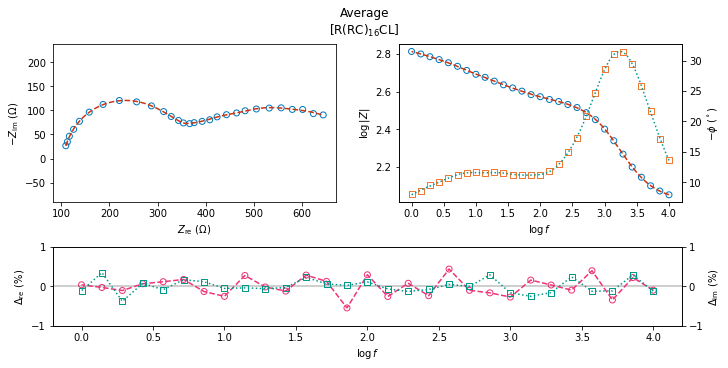

In [10]:
fig, axes = plot_fit(test, average)

Multiple test results can also be acquired by using the `perform_exploratory_tests` function instead of the `perform_test` function.
These results can then be scored and visualized using the `score_test_results` and `plot_exploratory_tests`.
This should make it easier to figure out if a result returned by `perform_test` is erroneous due to the underlying procedure[[2]](https://www.sciencedirect.com/science/article/abs/pii/S0013468614001005) stopping at a number of RC elements that is too low to ever properly fit a given impedance spectrum.
This can sometimes happen if the µ values fluctuate wildly enough at low numbers of RC elements.

In the example below, `perform_test` would have returned a result with only two RC elements while the combination of `perform_exploratory_results` and `score_test_results` suggests fifteen RC elements.
`score_test_results` returns a sorted list of tuples, which contain the score and the corresponding result, with the highest-scoring result as the first element.
Close proximity to the µ-criterion (as long as the µ value is below the µ-criterion) and a small χ² value contribute to a high score.

Num. RC: 2, mu: 0.846, log pseudo chi-squared: 0.71
Num. RC: 15, mu: 0.786, log pseudo chi-squared: -3.54


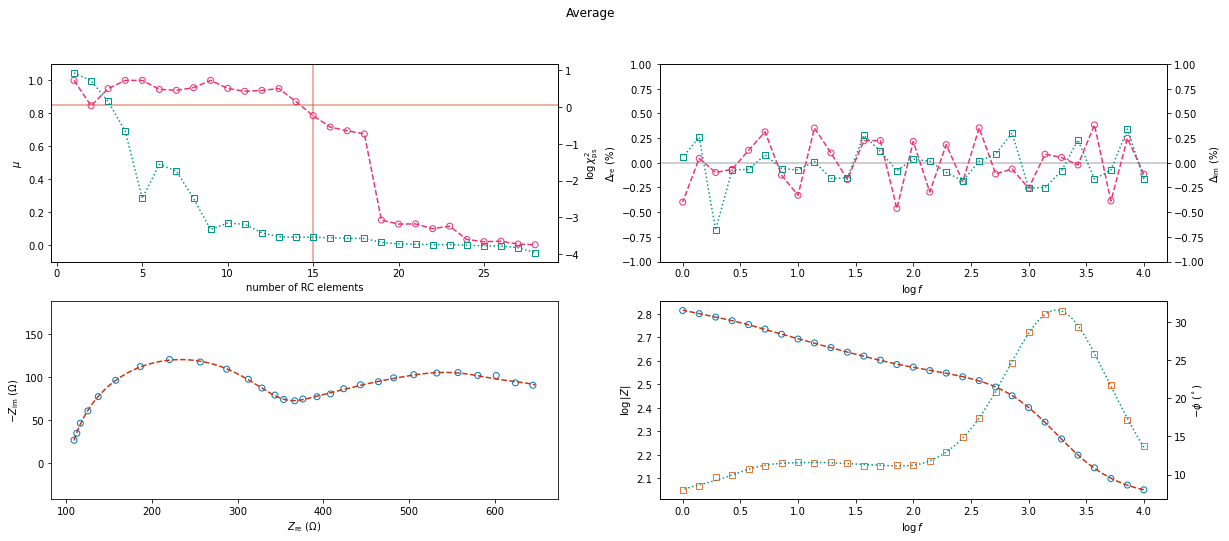

In [11]:
matplotlib.rcParams["figure.figsize"] = [20, 8]
mu_criterion = 0.85
results: List[KramersKronigResult] = perform_exploratory_tests(average, mu_criterion=mu_criterion)
scored_results: List[Tuple[float, KramersKronigResult]] = score_test_results(results, mu_criterion)
fig, axes = plot_exploratory_tests(scored_results, mu_criterion, average)
test = results[1]
print(f"Num. RC: {test.num_RC}, mu: {test.mu:.3f}, log pseudo chi-squared: {log(test.pseudo_chisqr):.2f}")
test = scored_results[0][1]
print(f"Num. RC: {test.num_RC}, mu: {test.mu:.3f}, log pseudo chi-squared: {log(test.pseudo_chisqr):.2f}")

## Creating and fitting equivalent circuits

A routine part of analyzing impedance spectra is to perform complex non-linear least squares (CNLS) fitting of equivalent circuits to the spectra.
The easiest way to construct an equivalent circuit with _pyimpspec_ is by letting _pyimpspec_ parse a circuit description code (CDC).
CDCs are used in many different programs that are made for analyzing impedance spectra and the syntax is similar across most of those programs.
Square brackets (`[]`) represent elements connected in series and parentheses (`()`) represent elements connected in parallel.
The various elements have their own symbols:

In [12]:
get_elements()

{'C': pyimpspec.circuit.capacitor.Capacitor,
 'G': pyimpspec.circuit.gerischer.Gerischer,
 'H': pyimpspec.circuit.havriliak_negami.HavriliakNegami,
 'L': pyimpspec.circuit.inductor.Inductor,
 'Ls': pyimpspec.circuit.de_levie.DeLevieFiniteLength,
 'Q': pyimpspec.circuit.constant_phase_element.ConstantPhaseElement,
 'R': pyimpspec.circuit.resistor.Resistor,
 'W': pyimpspec.circuit.warburg.Warburg,
 'Wo': pyimpspec.circuit.warburg.WarburgOpen,
 'Ws': pyimpspec.circuit.warburg.WarburgShort}

Some information about the elements and their parameters can be obtained as follows:

In [13]:
print(get_elements()["G"].get_extended_description())

Gerischer

Symbol: G

Z = 1/(Y*(k+j*2*pi*f)^n)

Variables
---------
Y: float = 1.0 (S*s^n)
k: float = 1.0 (s^-1)
n: float = 0.5


A circuit similar to the one shown below was used to generate the original spectrum albeit with different parameter values.
The impedance response of a circuit can be plotted with the `plot_circuit` function.

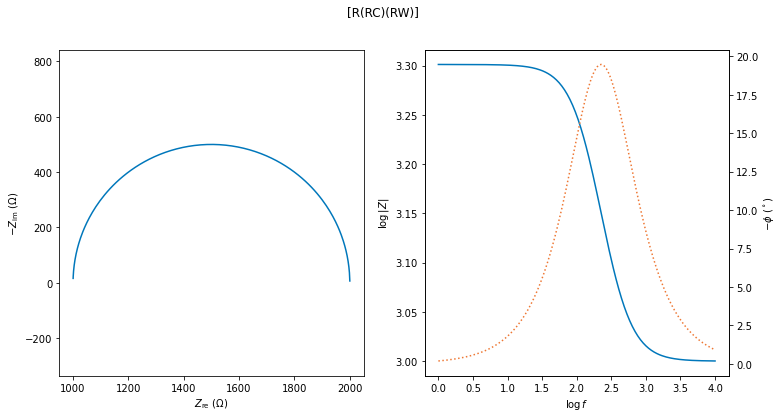

In [14]:
matplotlib.rcParams["figure.figsize"] = [12, 6]
circuit: Circuit = string_to_circuit("R(RC)(RW)")
fig, axes = plot_circuit(circuit, f=logspace(0, 4, num=41 * 5))

An equivalent circuit can be fitted to an impedance spectrum with the `fit_circuit_to_data` function.
The returned `FittingResult` object contains among other things a reference to a copy of the original circuit that has had its various parameters fitted.
The [`lmfit.minimizer.MinimizerResult`](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult) produced during fitting is also included in the `FittingResult` object.

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 54
    # data points      = 58
    # variables        = 5
    chi-square         = 4.7034e-09
    reduced chi-square = 8.8744e-11
    Akaike info crit   = -1337.65427
    Bayesian info crit = -1327.35206
[[Variables]]
    Y_4:  3.9972e-04 +/- 1.7997e-06 (0.45%) (init = 1)
    R_3:  501.222680 +/- 1.55701445 (0.31%) (init = 1000)
    C_2:  8.0128e-07 +/- 1.4349e-09 (0.18%) (init = 1e-06)
    R_1:  199.588625 +/- 0.36767854 (0.18%) (init = 1000)
    R_0:  100.006084 +/- 0.10974649 (0.11%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(Y_4, R_1) = 0.857
    C(Y_4, R_0) = 0.558
    C(Y_4, R_3) = 0.426
    C(R_1, R_0) = 0.309
    C(C_2, R_0) = 0.255
    C(R_3, R_0) = 0.211
    C(R_3, R_1) = 0.182


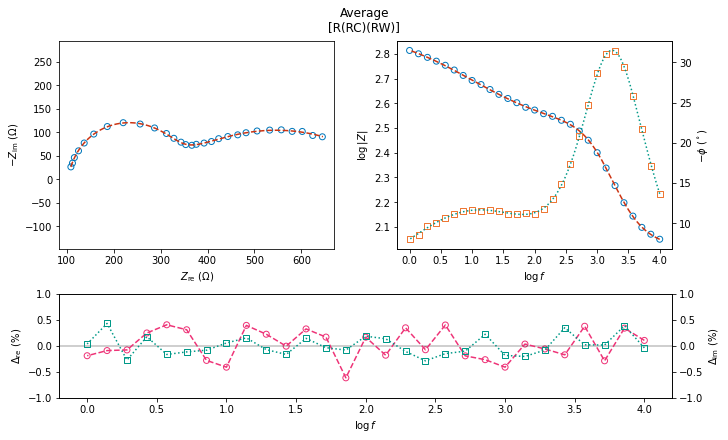

In [15]:
matplotlib.rcParams["figure.figsize"] = [10, 6]
fit: FittingResult = fit_circuit_to_data(circuit, average)
fig, axes = plot_fit(fit, average)
print(fit_report(fit.minimizer_result))

Information about the fitted parameters can also be output in various formats by creating a `pandas.DataFrame` object.
Below is an example of a LaTeX table.

In [16]:
print(fit.to_dataframe().to_latex(index=False, float_format="%.3g"))

\begin{tabular}{llrrl}
\toprule
Element & Parameter &    Value &  Std. err. (\%) & Fixed \\
\midrule
    R\_0 &         R &      100 &           0.11 &    No \\
    R\_1 &         R &      200 &          0.184 &    No \\
    C\_2 &         C & 8.01e-07 &          0.179 &    No \\
    R\_3 &         R &      501 &          0.311 &    No \\
    W\_4 &         Y &   0.0004 &           0.45 &    No \\
\bottomrule
\end{tabular}



/tmp/ipykernel_28217/2255452541.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fit.to_dataframe().to_latex(index=False, float_format="%.3g"))


`fit_circuit_to_data` has several parameters and by default the function tries several of the methods supported by [_lmfit_](https://lmfit.github.io/lmfit-py/fitting.html) as well as the various weight functions implemented in _pyimpspec_.
However, it may be necessary to modify the initial values and limits of parameters before performing a fit in order to achieve a good fit.
_pyimpspec_ supports an extended CDC syntax that allows you to specify the initial values and lower and/or upper limits of parameters, and element labels.

For example, the elements in the circuit created in the next cell can be broken down as follows.

`R{R=50/50%:sol}`

Set the initial value of the `R` parameter at 50 ohms, the lower limit at 50 % of the initial value, and omit the upper limit.
Set `sol` as the element label.

`C{C=1e-6/1e-8/1e-4:dl}`

Set the initial value of the `C` parameter at 1 µF, the lower limit at 10 nF, and the upper limit at 100 µF.
Set `dl` as the element label.

`R{R=800f:ct}`

Set the initial value of the `R` parameter at 800 ohms and make it a fixed value.
Set `ct` as the element label.

`W{Y=2.3e-4//1e-3}`

Set the initial value of the `Y` parameter at 0.23 mS\*s^(1/2), omit the lower limit, and set the upper limit at 1 mS\*s^(1/2).
Use the default label, which is the zero-based index assigned to the element.

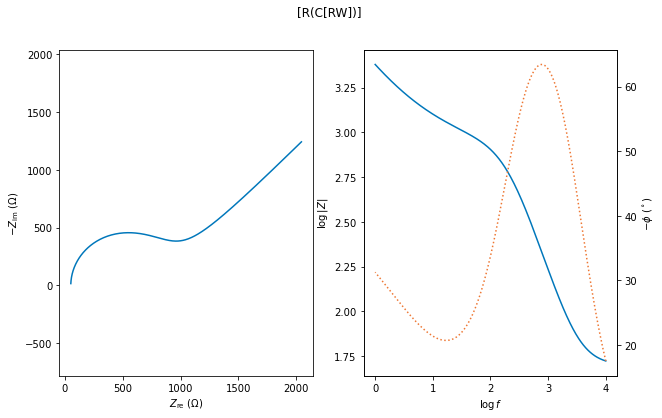

In [17]:
circuit = string_to_circuit("R{R=50/50%:sol}(C{C=1e-6/1e-8/1e-4:dl}[R{R=800f:ct}W{Y=2.3e-4//1e-3}])")
# Use the frequency range in the DataSet object (adding a visible_data=True argument would also plot the DataSet).
fig, axes = plot_circuit(circuit, data=average)

The LaTeX source required to draw a circuit diagram can also be generated.
Using the output requires the [_circuitikz_](https://ctan.org/pkg/circuitikz) package.

In [18]:
print(circuit.to_circuitikz())

\begin{circuitikz}
	\draw (0,0) node[above]{WE+WS} to[short, o-] (1,0);
	\draw (1.0,0.0) to[R=$R_{\rm sol}$] (3.0,0.0);
	\draw (3.0,-0.0) to[capacitor=$C_{\rm dl}$] (5.0,-0.0);
	\draw (3.0,-1.5) to[R=$R_{\rm ct}$] (5.0,-1.5);
	\draw (5.0,-1.5) to[generic=$W_{\rm 3}$] (7.0,-1.5);
	\draw (3.0,-0.0) to[short] (3.0,-1.5);
	\draw (7.0,-0.0) to[short] (7.0,-1.5);
	\draw (5.0,-0.0) to[short] (7.0,-0.0);
	\draw (7.0,0) to[short, -o] (8.0,0) node[above]{CE+RE};
\end{circuitikz}


![circuitikz](circuitikz-example.png)

## Customizing plots

The various `plot_*` functions return a `matplotlib.figure.Figure` object and one or more `matplotlib.axes.Axes` objects.
A set of figure and axes can be supplied to those functions in case you wish to use a different layout.
The returned figure and axis/axes can in either case be used to further alter the plots (e.g. adding legends).
Aside from the `plot_data`, `plot_fit`, `plot_exploratory_tests`, and `plot_circuit` functions, there are also functions for the individual subplots (i.e. `plot_nyquist`, `plot_bode`, etc.) that are used by the functions that were listed earlier.

The example below shows how one could go about adding legends to the various subplots of the figure produced by the `plot_fit` function.

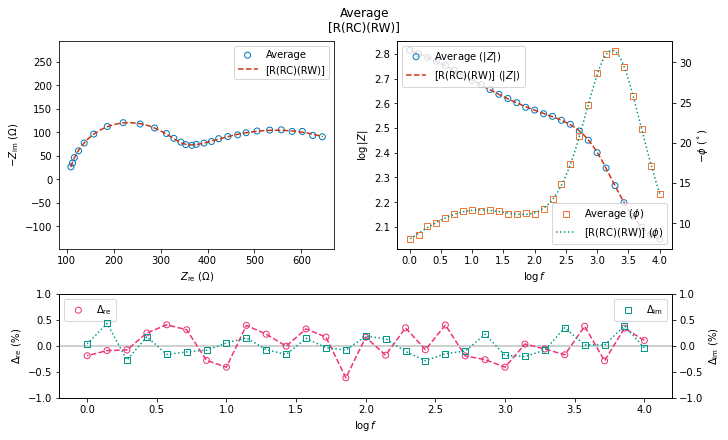

In [19]:
fig, axes = plot_fit(fit, average)
axes[0].legend(loc="upper right")  # Nyquist plot.
axes[1].legend(loc="upper left")  # Bode plot - base-10 logarithm of the absolute magnitude.
axes[2].legend(loc="lower right")  # Bode plot - negative phase shift.
axes[3].legend(loc="upper left")  # Residuals plot - residuals of the real parts.
axes[4].legend(loc="upper right")  # Residuals plot - residuals of the imaginary parts.